In [1]:
# imports
from copy import deepcopy
import numpy as np
from statistics import mean

import sys
sys.path.append('../src/')

from classification import get_stumps
from evaluation import central_train_accuracy, central_test_accuracy, edges, central_loss, losses_no_conf
from network import synthetic_graph, get_alphas
from related_works import colearning, alternating_colearning
from optimization import regularized_local_FW, local_FW, gd_reg_local_FW, centralized_FW
from utils import generate_fixed_moons, get_min_max

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# set graph of nodes with local personalized data
NB_ITER = 10000
D = 20
n = 200
NOISE_R = 0.05
random_state = 2017

BETA = 10

K, X, Y, X_test, Y_test, max_nb_instances, theta_true, angles, groundtruth_adj_matrix = generate_fixed_moons(D, sample_error_rate=NOISE_R, rnd_state=2017)

# set graph
nodes, adj_matrix, similarities = synthetic_graph(X, Y, X_test, Y_test, K, theta_true, max_nb_instances)

# set monitors for optimization analysis
monitors = {
    'train-accuracy': [central_train_accuracy, []],
    'test-accuracy': [central_test_accuracy, []],
    'loss': [central_loss, []],
}

# get weak classifiers
vmin, vmax = get_min_max(X)
base_clfs = get_stumps(n=n, d=D+1, min_v=vmin, max_v=vmax)

results = {}

colors = {
    "global l1 Adaboost": "g",
    "purely local models": "k",
    "Dada exponential": "b",
    "personalized linear": "m", 
    "Dada": "c",
    "personalized linear gd": "y",
}

In [3]:
nodes_copy = deepcopy(nodes)
results["Dada exponential"] = regularized_local_FW(nodes_copy, base_clfs, beta=BETA, nb_iter=NB_ITER, 
                                mu=1, monitors=monitors, checkevery=100)

In [4]:
centralized_nodes = deepcopy(nodes)
centralized_FW(centralized_nodes, base_clfs, beta=BETA, nb_iter=1000, monitors={})
results["global l1 Adaboost"] = {}
results["global l1 Adaboost"]["train-accuracy"] = central_train_accuracy(centralized_nodes)
results["global l1 Adaboost"]["test-accuracy"] = central_test_accuracy(centralized_nodes)

local_nodes = deepcopy(nodes)
local_FW(local_nodes, base_clfs, beta=BETA, nb_iter=1000, monitors={})
results["purely local models"] = {}
results["purely local models"]["train-accuracy"] = central_train_accuracy(local_nodes)
results["purely local models"]["test-accuracy"] = central_test_accuracy(local_nodes)

# global_nodes = deepcopy(nodes)
# global_regularized_local_FW(global_nodes, base_clfs, beta=BETA, nb_iter=NB_ITER, monitors={})
# results["global-local mixture"] = {}
# results["global-local mixture"]["train-accuracy"] = central_train_accuracy(global_nodes)
# results["global-local mixture"]["test-accuracy"] = central_test_accuracy(global_nodes)

In [5]:
results["personalized linear"], clf_colearning = colearning(K, X, Y, X_test, Y_test, D, NB_ITER, adj_matrix, 
                                similarities, mu=1, max_samples_per_node=max_nb_instances, checkevery=100)

In [3]:
from evaluation import kalo_objective
from optimization import kalo_graph_discovery

# graph discovery
gd_pace = 500

MU, LA = 0.1, 1

monitors = {
    'train-accuracy': [central_train_accuracy, []],
    'test-accuracy': [central_test_accuracy, []],
    'edges': [edges, []],
    'obj-function': [kalo_objective, [MU, LA]],
}

gd_nodes = deepcopy(nodes)
results["Dada"] = gd_reg_local_FW(gd_nodes, base_clfs, gd_method={"name":"kalo", "pace_gd": gd_pace, 
                    "args":(MU, LA)}, beta=BETA, mu=MU, nb_iter=20000, monitors=monitors, checkevery=100)

# Accuracy and Convergence

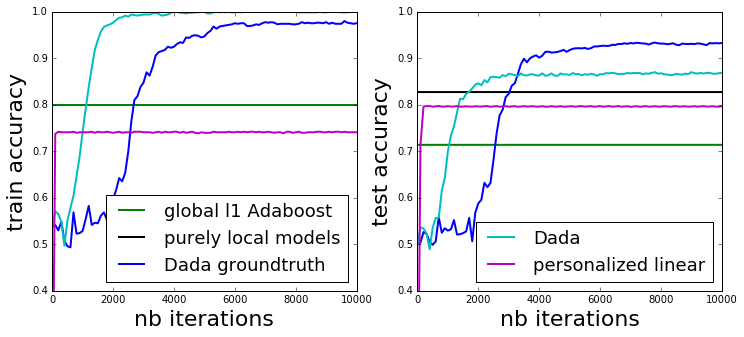

In [7]:
plt.figure(1, figsize=(12, 5))

max_iter = NB_ITER
plt.subplot(121)
plt.xlabel('nb iterations', fontsize=22)
plt.ylabel('train accuracy', fontsize=22)
plt.xlim(0, max_iter)
plt.ylim(0.4, 1)

for k, r_list in results.items():
    label = k
    if k in ['Dada exponential', 'Dada', 'personalized linear']:
        label = '_nolegend_'
    try:
        plt.plot([i*100 for i in range(len(r_list))], [r['train-accuracy'] for r in r_list], label=label, color=colors[k], linewidth=2)
    except:
        plt.plot(range(NB_ITER+1), [r_list['train-accuracy']]*(NB_ITER+1), label=label, color=colors[k], linewidth=2)

plt.legend(loc='lower right', fontsize=18)

plt.subplot(122)
plt.xlabel('nb iterations', fontsize=22)
plt.ylabel('test accuracy', fontsize=22)
plt.xlim(0, max_iter)
plt.ylim(0.4, 1)

for k, r_list in results.items():
    label = '_nolegend_'
    if k in ['Dada exponential', 'Dada', 'personalized linear']:
        label = '{}'.format(k)
    try:
        plt.plot([i*100 for i in range(len(r_list))], [r['test-accuracy'] for r in r_list], label=label, color=colors[k], linewidth=2)
    except:
        plt.plot(range(NB_ITER+1), [r_list['test-accuracy']]*(NB_ITER+1), label=label, color=colors[k], linewidth=2)

plt.legend(loc='lower right', fontsize=18)

plt.savefig("moons-clust-acc.pdf")

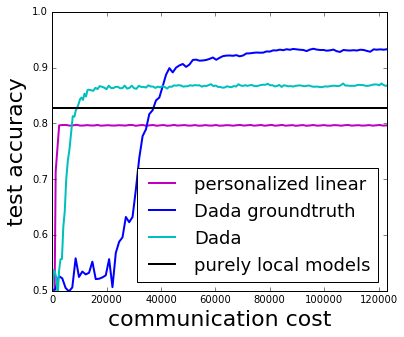

In [15]:
from math import log

Z = 32
# test accuracy vs communication
linear_com = 2*D*Z
regularized_com = [np.sum(r['edges'])/K *(Z + log(n)) for r in results['Dada']]
exponential_com = np.sum(adj_matrix)/K *(Z + log(n))

x_linear = [linear_com*i for i in range(len(results['personalized linear']))]
x_dada = [sum(regularized_com[:i]) for i in range(len(results['Dada']))]
x_exponential = [exponential_com*i for i in range(len(results['Dada groundtruth']))]

plt.figure(1, figsize=(6, 5))

plt.xlabel('communication cost', fontsize=22)
plt.ylabel('test accuracy', fontsize=22)

plt.plot(x_linear, [r['test-accuracy'] for r in results['personalized linear']], label='personalized linear', color=colors['personalized linear'], linewidth=2)
plt.plot(x_exponential, [r['test-accuracy'] for r in results['Dada groundtruth']], label='Dada groundtruth', color=colors['Dada groundtruth'], linewidth=2)
plt.plot(x_dada, [r['test-accuracy'] for r in results['Dada']], label='Dada', color=colors['Dada'], linewidth=2)
plt.plot([0, min(max(x_dada), max(x_linear))], [results["purely local models"]["test-accuracy"]]*2, label='purely local models', color=colors['purely local models'], linewidth=2)

plt.xlim(0, min(max(x_dada), max(x_linear), max(x_exponential)))
plt.ylim(0.5, 1)
plt.legend(loc="lower right", fontsize=18)

plt.savefig("moons-clust-comm.pdf")

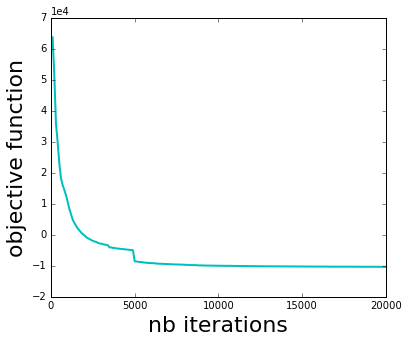

In [9]:
# convergence
plt.figure(1, figsize=(6, 5))

plt.xlabel('nb iterations', fontsize=22)
plt.ylabel('objective function', fontsize=22)

for k, r_list in results.items():
    try:
        plt.plot([i*100 for i in range(len(r_list))], [r['obj-function'] for r in r_list], label=k, color=colors[k], linewidth=2)
    except:
        pass

plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))


# plt.legend(loc='upper right', fontsize=22)
plt.savefig("moons-clust-loss.pdf")

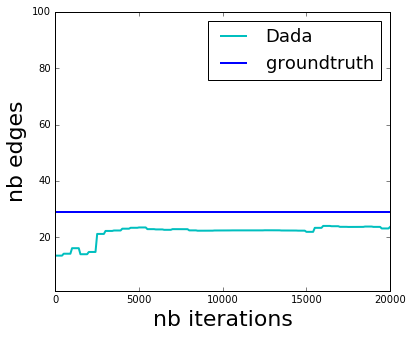

In [22]:
plt.figure(1, figsize=(6, 5))

plt.xlabel('nb iterations', fontsize=22)
plt.ylabel('nb edges', fontsize=22)
plt.xlim(0, 20000)
plt.ylim(1, K)

plt.plot([i*100 for i in range(len(results["Dada"]))], [np.mean(r['edges']) for r in results["Dada"]], color="c", label="Dada", linewidth=2)
plt.plot([0, 20000], [np.mean(np.sum(groundtruth_adj_matrix, axis=0))]*2, label="groundtruth", color="b", linewidth=2)

# print(np.mean())
plt.legend(loc='upper right', fontsize=18)

plt.savefig("moons-clust-edges.pdf")

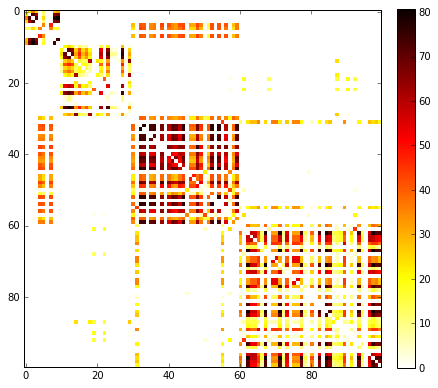

In [6]:
plt.figure(1, figsize=(7, 10))

cax = plt.imshow(results["Dada"][-1]["similarities"], cmap='hot_r', interpolation='nearest')
plt.colorbar(cax, orientation='vertical', fraction=0.046, pad=0.04)

plt.savefig("moons-clust-heat1.pdf")

## Graph correlations

In [26]:
from scipy.stats import spearmanr

matrix_angles = np.empty((K, K))
for i in range(K):
    for j in range(K):
        matrix_angles[i, j] = abs(angles[i] - angles[j])

print("Correlation with angles")
print("kalo", spearmanr(matrix_angles, results["Dada"][-1]["similarities"], axis=None))

print("\nCorrelation with similarities")
print("kalo", spearmanr(similarities, results["Dada"][-1]["similarities"], axis=None))

Correlation with angles
kalo SpearmanrResult(correlation=-0.42965759122400071, pvalue=0.0)

Correlation with similarities
kalo SpearmanrResult(correlation=0.50523601002780594, pvalue=0.0)


In [10]:
def get_edges_weights(adj_matrix, similarities):
    edges = []
    weights = []
    for i in range(K):
        for j in range(i, K):
            if adj_matrix[i, j]:
                edges.append((i, j))
                weights.append(similarities[i, j])
    return edges, weights

In [11]:
import networkx as nx

STEP = gd_pace
kalo_graph = nx.from_numpy_matrix(results["Dada"][-1]["adj-matrix"])
kalo_edges, kalo_weights = get_edges_weights(results["Dada"][-1]["adj-matrix"], results["Dada"][-1]["similarities"])

groundtruth_graph = nx.from_numpy_matrix(adj_matrix)
gr_edges, gr_weights = get_edges_weights(adj_matrix, similarities)

pos_kalo = nx.spring_layout(kalo_graph)
pos = nx.spring_layout(groundtruth_graph)

print("number of  non-negligible edges", sum(results["Dada"][-1]["edges"]))
for i in [10**j for j in range(-6, 2)]:
    print("nb edges w >", i, ":", np.count_nonzero(results["Dada"][-1]["similarities"] > i))

number of  non-negligible edges 2410
nb edges w > 1e-06 : 2426
nb edges w > 1e-05 : 2426
nb edges w > 0.0001 : 2418
nb edges w > 0.001 : 2410
nb edges w > 0.01 : 1942
nb edges w > 0.1 : 1854
nb edges w > 1 : 1714
nb edges w > 10 : 774


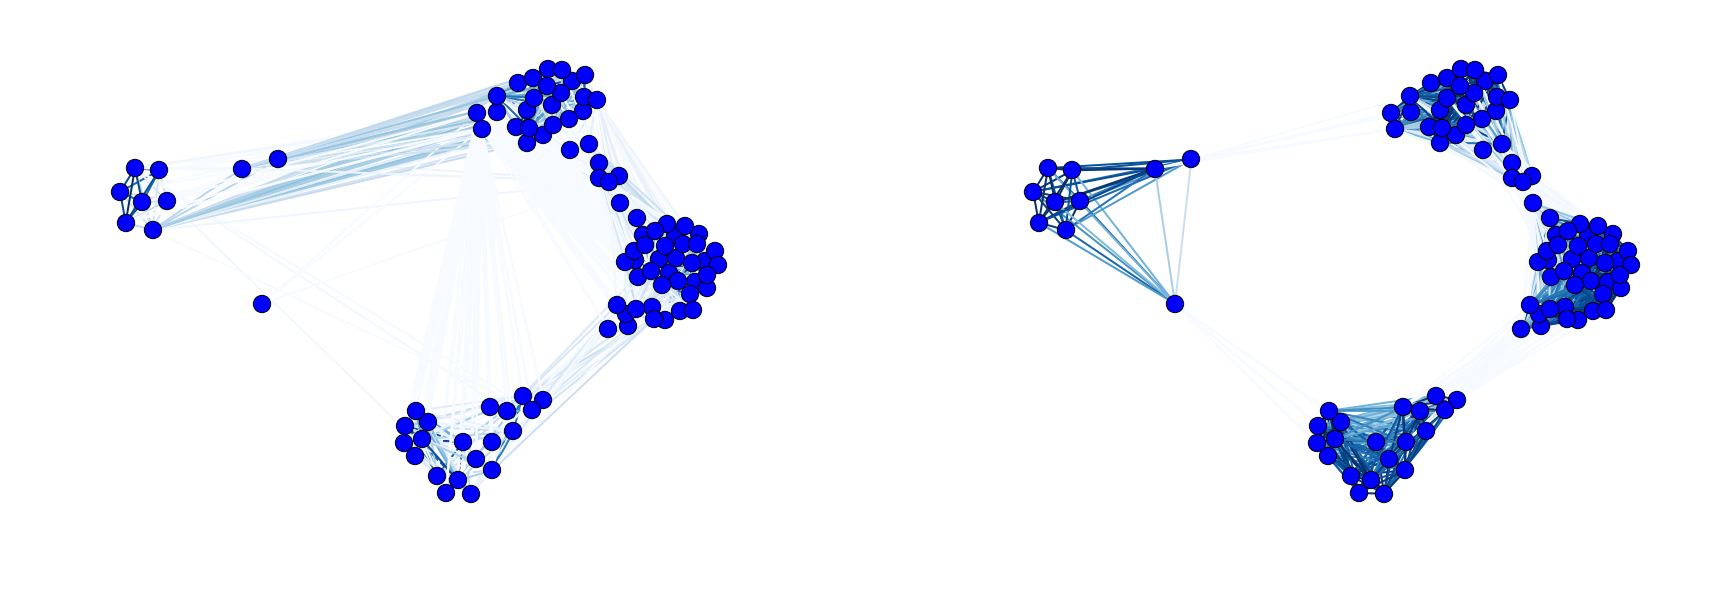

In [12]:
plt.figure(1, figsize=(30, 10))

plt.subplot(121)
# plt.title('Optimized')
nx.draw(kalo_graph, pos, node_color='b', edgelist=kalo_edges, edge_color=kalo_weights, width=2.0, edge_cmap=plt.cm.Blues)

plt.subplot(122)
# plt.title('Groundtruth')
nx.draw(groundtruth_graph, pos, node_color='b', edgelist=gr_edges, edge_color=gr_weights, width=2.0, edge_cmap=plt.cm.Blues)

plt.savefig("moons-clust-graphs.pdf")

Angles as labels, 2**(loss*confidence) as size


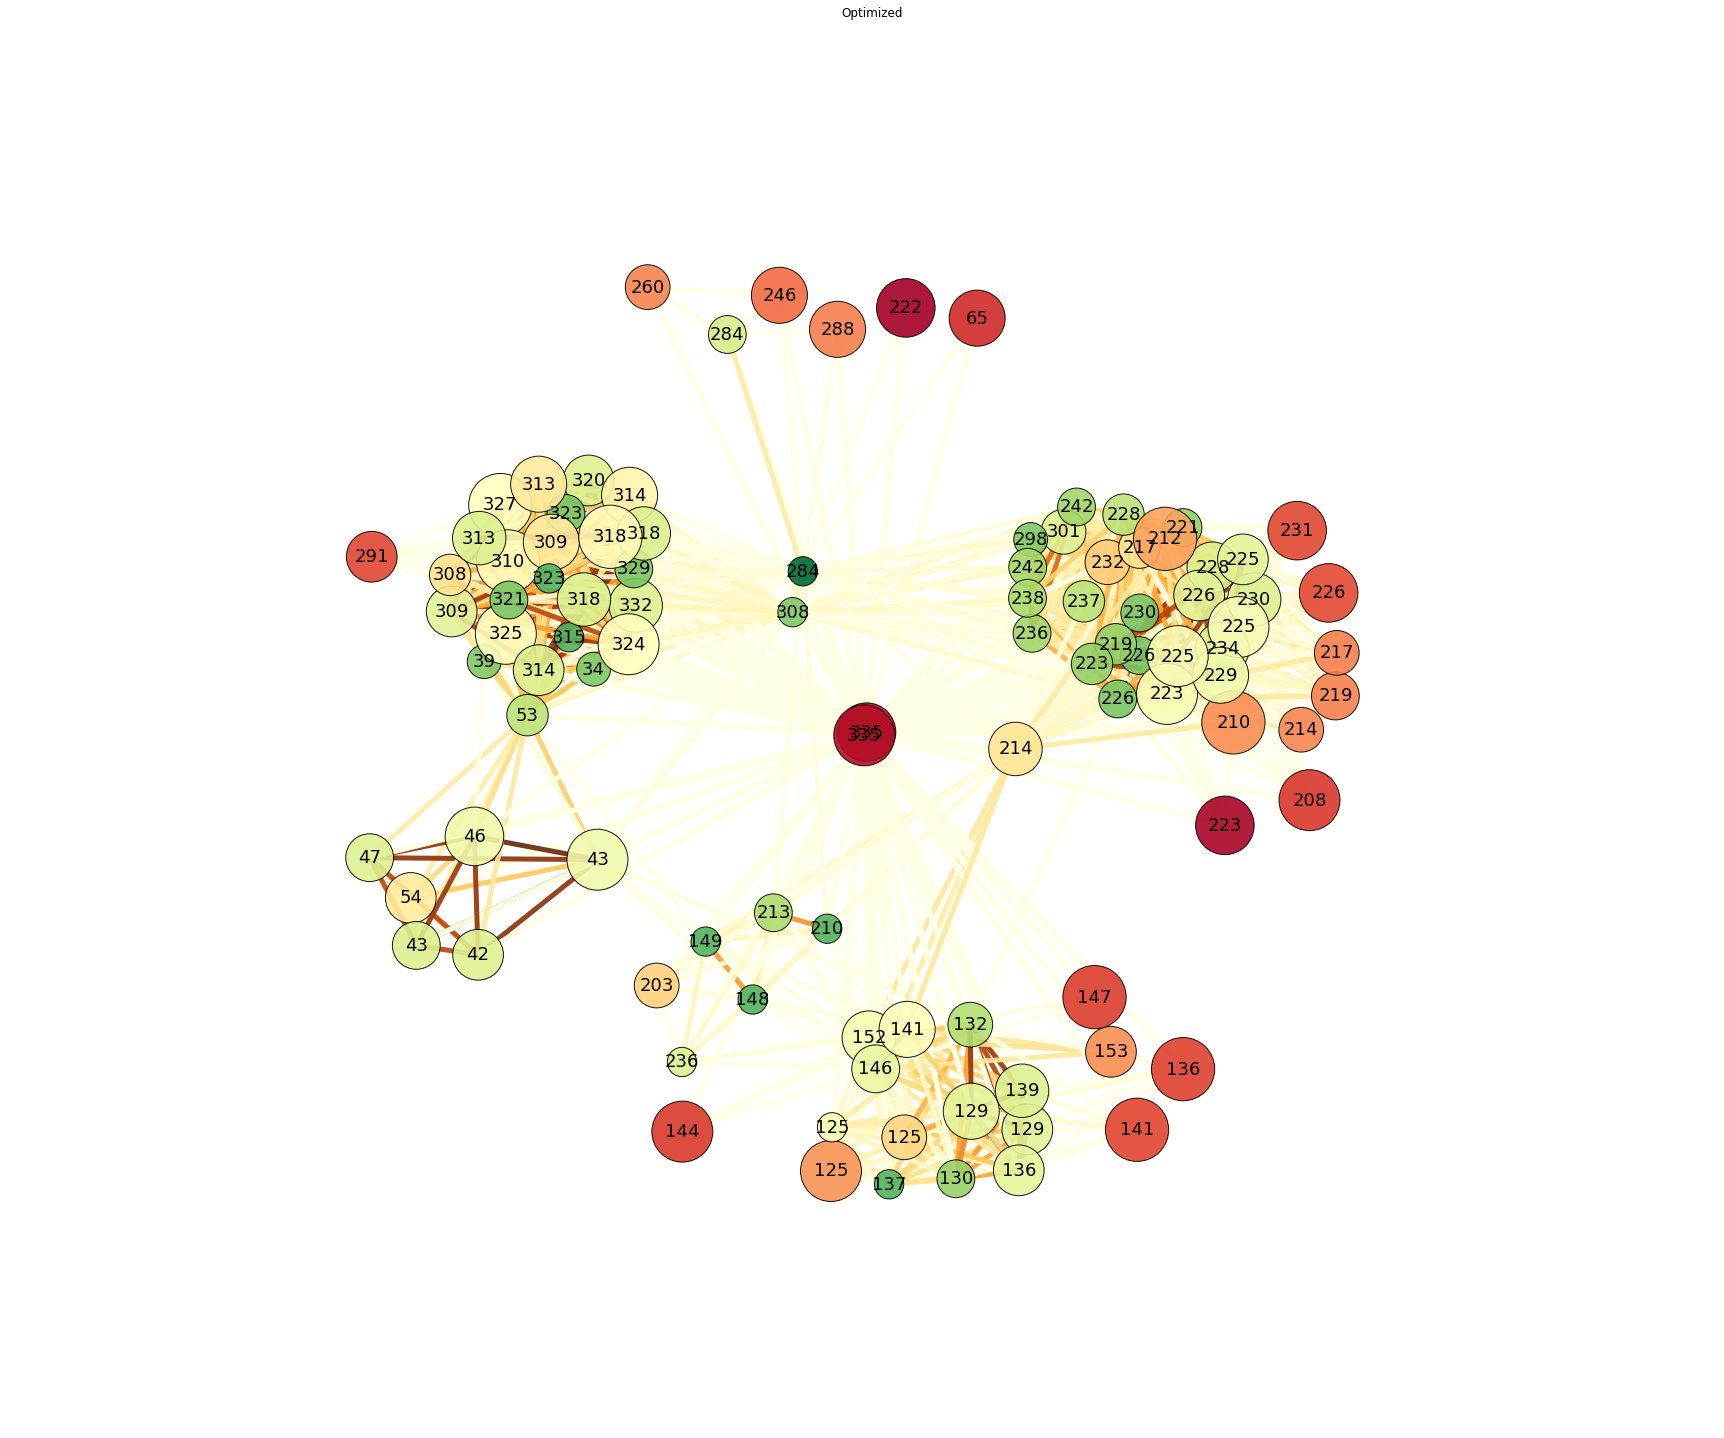

In [15]:
import math

l_list = losses_no_conf(gd_nodes)
plt.figure(1, figsize=(30, 25))

plt.title('Optimized')
nx.draw(kalo_graph, pos_kalo, node_color=[1-l for l in l_list], node_size=[4000*n.confidence for n in nodes], edgelist=kalo_edges, edge_color=kalo_weights, alpha=0.9, width=5.0, cmap=plt.cm.RdYlGn, edge_cmap=plt.cm.YlOrBr)
nx.draw_networkx_labels(kalo_graph, pos_kalo, labels={i:int(a*180/math.pi) for i,a in enumerate(angles)}, font_size=18, font_color='k', alpha=1.0, ax=None)

print("Angles as labels, 2**(loss*confidence) as size")

## Accuracy vs sparsity


In [19]:
B_LIST = [j * 10**i for i in range(-3, 3) for j in range(1, 10, 2)]
results_kalo = {}
# results_kalo = {}.fromkeys(B_LIST, {"train-accuracy": [], "test-accuracy": [], "mean-edges": []})
NB_ITER = 10000
MU = 0.1
gd_pace = 500

for b in B_LIST:
    print(b)
    results_kalo[b] = {"train-accuracy": [], "test-accuracy": [], "mean-edges": []}

    for _ in range(2):
                
        gd_nodes = deepcopy(nodes)
        gd_reg_local_FW(gd_nodes, base_clfs, gd_method={"name":"kalo", "pace_gd": gd_pace, "args":(MU, b)},
                        beta=BETA, mu=MU, nb_iter=NB_ITER, monitors={})

        results_kalo[b]["train-accuracy"].append(central_train_accuracy(gd_nodes))
        results_kalo[b]["test-accuracy"].append(central_test_accuracy(gd_nodes))        
        results_kalo[b]["mean-edges"].append(np.mean(edges(gd_nodes)))

for b in B_LIST:
    results_kalo[b]["train-accuracy"] = np.mean(results_kalo[b]["train-accuracy"])    
    results_kalo[b]["test-accuracy"] = np.mean(results_kalo[b]["test-accuracy"])
    results_kalo[b]["mean-edges"] = np.mean(results_kalo[b]["mean-edges"])


0.001
0.003
0.005
0.007
0.009000000000000001
0.01
0.03
0.05
0.07
0.09
0.1
0.30000000000000004
0.5
0.7000000000000001
0.9
1
3
5
7
9
10
30
50
70
90
100
300
500
700
900


In [26]:
# avg results by lambda
keys = []

for la in B_LIST:
    keys.append(results_kalo[la]["mean-edges"])

keys = set(keys)

# sort results
train = {k: list() for k in keys}
test = {k: list() for k in keys}

for la, value in results_kalo.items():
    train[value["mean-edges"]].append(value["train-accuracy"])
    test[value["mean-edges"]].append(value["test-accuracy"])

sorted_keys = sorted(keys) 

{26.77, 26.379999999999999, 26.689999999999998, 27.050000000000001, 27.82, 27.18, 28.539999999999999, 28.189999999999998, 28.490000000000002, 29.039999999999999, 29.829999999999998, 29.359999999999999, 30.73, 25.780000000000001, 26.98, 26.800000000000001, 28.93, 28.280000000000001, 30.399999999999999, 30.960000000000001, 28.439999999999998, 28.0, 28.039999999999999, 29.869999999999997, 29.130000000000003, 29.379999999999999, 30.940000000000001, 30.359999999999999, 31.149999999999999, 25.43}


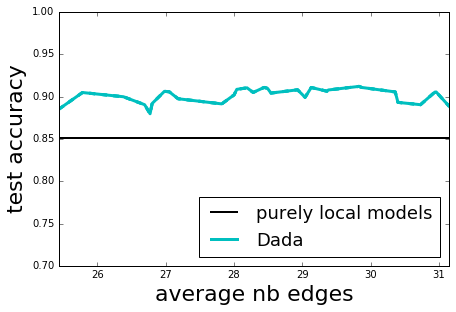

In [28]:
import operator
plt.figure(1, figsize=(7, 10))

# plt.subplot(211)
# plt.xlabel('mean nb edges', fontsize=22)
# plt.ylabel('train accuracy', fontsize=22)


# y = [np.mean(train[k]) for k in sorted_keys]
# std = [np.std(train[k]) for k in sorted_keys]

# plt.plot([0,K], [results['purely local models']['train-accuracy']]*2, label='purely local models', linewidth=2)
# plt.plot(sorted_keys, y, label='Dada', linewidth=3, color="c")
# plt.plot(sorted_keys, list(map(operator.sub, y, std)), '--', linewidth=3, color="c")
# plt.plot(sorted_keys, list(map(operator.add, y, std)), '--', linewidth=3, color="c")
# # plt.scatter([value[] for k, value in results_kalo.items()], [], linewidth=1)
# plt.xlim(min(sorted_keys), max(sorted_keys))
# plt.ylim(0.7, 1)

# plt.legend(loc='center right', fontsize=18)

plt.subplot(212)
plt.xlabel('average nb edges', fontsize=22)
plt.ylabel('test accuracy', fontsize=22)

y = [np.mean(test[k]) for k in sorted_keys]
std = [np.std(test[k]) for k in sorted_keys]
# print(y, sorted_keys)
plt.plot([0, K], [results['purely local models']['test-accuracy']]*2, label='purely local models', linewidth=2, color='k')
plt.plot(sorted_keys, y, label='Dada', linewidth=3, color='c')
plt.plot(sorted_keys, list(map(operator.sub, y, std)), '--', linewidth=3, color="c")
plt.plot(sorted_keys, list(map(operator.add, y, std)), '--', linewidth=3, color="c")

plt.xlim(min(sorted_keys), max(sorted_keys))
plt.ylim(0.7, 1)

plt.legend(loc='lower right', fontsize=18)

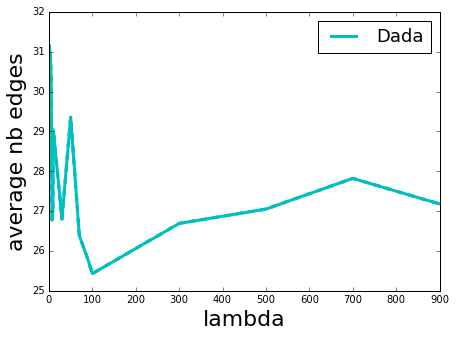

In [29]:
plt.figure(1, figsize=(7, 5))

plt.xlabel('lambda', fontsize=22)
plt.ylabel('average nb edges', fontsize=22)

y = [np.mean(results_kalo[la]["mean-edges"]) for la in LA_LIST]
std = [np.std(results_kalo[la]["mean-edges"]) for la in LA_LIST]
plt.plot(LA_LIST, y, label='Dada', linewidth=3, color="c")
plt.plot(LA_LIST, list(map(operator.sub, y, std)), '--', linewidth=3, color="c")
plt.plot(LA_LIST, list(map(operator.add, y, std)), '--', linewidth=3, color="c")

plt.legend(loc='upper right', fontsize=18)